## Package Import

In [1]:
import math
from math import sqrt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
import warnings
warnings.filterwarnings("ignore")
import fancyimpute
from fancyimpute import IterativeImputer as MICE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

Using TensorFlow backend.


## Data Read and Exploration

In [2]:
train = pd.read_excel("Data_Train.xlsx", index_col = None,na_values ='-', )
train.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",₹200,₹50,3.5,12.0,4.0,30 minutes
1,ID_2882,"Sector 3, Marathalli","Ice Cream, Desserts",₹100,₹50,3.5,11.0,4.0,30 minutes
2,ID_1595,Mumbai Central,"Italian, Street Food, Fast Food",₹150,₹50,3.6,99.0,30.0,65 minutes
3,ID_5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",₹250,₹99,3.7,176.0,95.0,30 minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",₹200,₹99,3.2,521.0,235.0,65 minutes


In [3]:
print(len(train[train.duplicated()]))
train.isnull().sum()

0


Restaurant          0
Location            0
Cuisines            0
Average_Cost        0
Minimum_Order       0
Rating           1191
Votes            2074
Reviews          2312
Delivery_Time       0
dtype: int64

In [4]:
print("The shape of training set is " , train.shape, '\n')
col = train.columns
for i in col:
    print("Length of unique values of",i, "is", len(train[i].unique()),'\n')
    print("Unique values of are :" ,'\n')
    print(train[i].unique())
    print("-----------------------------------------------------------------------------", '\n')

The shape of training set is  (11094, 9) 

Length of unique values of Restaurant is 7480 

Unique values of are : 

['ID_6321' 'ID_2882' 'ID_1595' ... 'ID_3392' 'ID_4115' 'ID_4417']
----------------------------------------------------------------------------- 

Length of unique values of Location is 35 

Unique values of are : 

['FTI College, Law College Road, Pune' 'Sector 3, Marathalli'
 'Mumbai Central' 'Sector 1, Noida' 'Rmz Centennial, I Gate, Whitefield'
 'Delhi University-GTB Nagar' 'Yerawada, Pune, Maharashtra'
 'Delhi Administration Flats, Timarpur' 'Moulali, Kolkata'
 'Dockyard Road, Mumbai CST Area' 'Pune University'
 'Gora Bazar, Rajbari, North Dumdum, Kolkata' 'D-Block, Sector 63, Noida'
 'Sector 14, Noida' 'Mico Layout, Stage 2, BTM Layout,Bangalore'
 'Laxman Vihar Industrial Area, Sector 3A, Gurgoan' 'Tiretti, Kolkata'
 'Sandhurst Road, Mumbai CST Area' 'MG Road, Pune'
 'Hyderabad Public School, Begumpet' 'Majestic' 'Chandni Chowk, Kolkata'
 'Delhi High Court, India Gat

## Data Cleaning

In [5]:
print("'For' in place of price :", len(train[train['Average_Cost']=='for']),'\n')
train[train['Average_Cost']=='for']

'For' in place of price : 1 



,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
6297,ID_6472,Pune University,Fast Food,for,₹50,NEW,NaN,NaN,30 minutes


In [6]:
train[train['Restaurant']=='ID_6472']

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
5988,ID_6472,"D-Block, Sector 63, Noida",Fast Food,₹200,₹99,3.7,1056.0,329.0,65 minutes
6297,ID_6472,Pune University,Fast Food,for,₹50,NEW,NaN,NaN,30 minutes


In [7]:
train['Average_Cost']= train['Average_Cost'].replace('for',200)
len(train[train['Average_Cost']=='for'])

0

In [8]:
print("Rating - Opening Soon :", len(train[train['Rating']=='Opening Soon']))
print("Rating - Temporarily Closed :", len(train[train['Rating']=='Temporarily Closed']))
print("Rating - NEW :", len(train[train['Rating']=='NEW']))

Rating - Opening Soon : 12
Rating - Temporarily Closed : 2
Rating - NEW : 758


In [9]:
train['Minimum_Order']=train.Minimum_Order.apply(lambda x: x.replace('₹',''))
train['Minimum_Order']=train.Minimum_Order.apply(lambda x: x.replace(',',''))
train['Minimum_Order']=train['Minimum_Order'].astype(int)

train['Average_Cost'] = train.Average_Cost.apply(lambda x: str(x).replace('₹',''))
train['Average_Cost'] = train.Average_Cost.apply(lambda x: str(x).replace(',',''))
train['Average_Cost']=train['Average_Cost'].astype(int)

(array([6.792e+03, 4.280e+02, 1.770e+02, 2.400e+01, 1.000e+01, 1.400e+01,
        6.000e+00, 1.000e+01, 3.000e+00, 3.000e+00, 6.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ,
        16.4, 17.8, 19.2, 20.6, 22. ]),
 <a list of 15 Patch objects>)

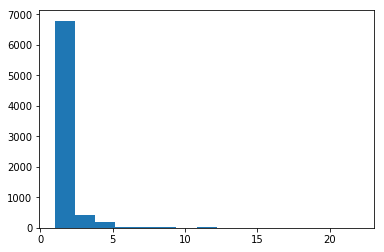

In [10]:
plt.hist(train.Restaurant.value_counts(), bins=15)

In [11]:
train['Delivery_Time'].value_counts()

30 minutes     7406
45 minutes     2665
65 minutes      923
120 minutes      62
20 minutes       20
80 minutes       14
10 minutes        4
Name: Delivery_Time, dtype: int64

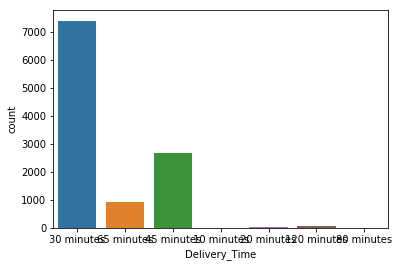

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x='Delivery_Time', data=train)

## Cuisines Cleaning

In [13]:
train['Cuisines'] = train['Cuisines'].str.lower()
train['Cuisines'] = train['Cuisines'].str.replace(' ','')

In [14]:
ntrain = train.shape[0]
dftemp = train[:ntrain]
dftemp.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time
0,ID_6321,"FTI College, Law College Road, Pune","fastfood,rolls,burger,salad,wraps",200,50,3.5,12.0,4.0,30 minutes
1,ID_2882,"Sector 3, Marathalli","icecream,desserts",100,50,3.5,11.0,4.0,30 minutes
2,ID_1595,Mumbai Central,"italian,streetfood,fastfood",150,50,3.6,99.0,30.0,65 minutes
3,ID_5929,"Sector 1, Noida","mughlai,northindian,chinese",250,99,3.7,176.0,95.0,30 minutes
4,ID_6123,"Rmz Centennial, I Gate, Whitefield","cafe,beverages",200,99,3.2,521.0,235.0,65 minutes


In [15]:
from collections import Counter
cuisines_list = train['Cuisines'].str.split(',')
cuisines_counter = Counter(([a for b in cuisines_list.tolist() for a in b]))
#cuisines_counter

In [16]:
cuisines_list_set = set([a for b in cuisines_list.tolist() for a in b])
for cuisine in cuisines_list_set:
    (cuisine, ": ", train[dftemp['Cuisines'].str.contains(cuisine)]['Average_Cost'].mean())

In [17]:
train['Cuisines'] = train['Cuisines'].str.replace('northindian','indian')
train['Cuisines'] = train['Cuisines'].str.replace('southindian','indian')
train['Cuisines'] = train['Cuisines'].str.replace('kerala','indian')
train['Cuisines'] = train['Cuisines'].str.replace('bihari','indian')
train['Cuisines'] = train['Cuisines'].str.replace('lucknowi','indian')
train['Cuisines'] = train['Cuisines'].str.replace('mangalorean','indian')
train['Cuisines'] = train['Cuisines'].str.replace('hyderabadi','indian')
train['Cuisines'] = train['Cuisines'].str.replace('andhra','indian')
train['Cuisines'] = train['Cuisines'].str.replace('assamese','indian')
train['Cuisines'] = train['Cuisines'].str.replace('maharashtrian','indian')
train['Cuisines'] = train['Cuisines'].str.replace('parsi','indian')
train['Cuisines'] = train['Cuisines'].str.replace('odia','indian')
train['Cuisines'] = train['Cuisines'].str.replace('tamil','indian')
train['Cuisines'] = train['Cuisines'].str.replace('bohri','indian')
train['Cuisines'] = train['Cuisines'].str.replace('goan','indian')
train['Cuisines'] = train['Cuisines'].str.replace('gujarati','indian')
train['Cuisines'] = train['Cuisines'].str.replace('rajasthani','indian')
train['Cuisines'] = train['Cuisines'].str.replace('konkan','indian')
train['Cuisines'] = train['Cuisines'].str.replace('naga','indian')
train['Cuisines'] = train['Cuisines'].str.replace('modernindian','indian')
train['Cuisines'] = train['Cuisines'].str.replace('awadhi','indian')
train['Cuisines'] = train['Cuisines'].str.replace('kashmiri','indian')
train['Cuisines'] = train['Cuisines'].str.replace('malwani','indian')
train['Cuisines'] = train['Cuisines'].str.replace('bengali','indian')
train['Cuisines'] = train['Cuisines'].str.replace('chettinad','indian')
train['Cuisines'] = train['Cuisines'].str.replace('paan','indian')

train['Cuisines'] = train['Cuisines'].str.replace('salad','continental')
train['Cuisines'] = train['Cuisines'].str.replace('seafood','continental')
train['Cuisines'] = train['Cuisines'].str.replace('mediterranean','continental')
train['Cuisines'] = train['Cuisines'].str.replace('continental','continental')
train['Cuisines'] = train['Cuisines'].str.replace('srilankan','international')

train['Cuisines'] = train['Cuisines'].str.replace('rolls','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('steak','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('burger','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('pizza','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('hotdogs','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('tex-mex','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('wraps','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('momos','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('sandwich','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('poké','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('fingerfood','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('barfood','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('mughlai','fastfood')
train['Cuisines'] = train['Cuisines'].str.replace('streetfood','fastfood')

train['Cuisines'] = train['Cuisines'].str.replace('icecream','desserts')
train['Cuisines'] = train['Cuisines'].str.replace('mithai','desserts')
train['Cuisines'] = train['Cuisines'].str.replace('mishti','desserts')
train['Cuisines'] = train['Cuisines'].str.replace('bakery','desserts')
train['Cuisines'] = train['Cuisines'].str.replace('frozenyogurt','desserts')

train['Cuisines'] = train['Cuisines'].str.replace('cafe','beverages')
train['Cuisines'] = train['Cuisines'].str.replace('bubbletea','beverages')
train['Cuisines'] = train['Cuisines'].str.replace('tea','beverages')
train['Cuisines'] = train['Cuisines'].str.replace('juices','beverages')
train['Cuisines'] = train['Cuisines'].str.replace('coffee','beverages')

train['Cuisines'] = train['Cuisines'].str.replace('kebab','meat')
train['Cuisines'] = train['Cuisines'].str.replace('bbq','meat')
train['Cuisines'] = train['Cuisines'].str.replace('rawmeats','meat')
train['Cuisines'] = train['Cuisines'].str.replace('roastchicken','meat')
train['Cuisines'] = train['Cuisines'].str.replace('charcoalchicken','meat')

In [18]:
train['Cuisines'] = train['Cuisines'].str.replace('italian','european')
train['Cuisines'] = train['Cuisines'].str.replace('indonesian','european')
train['Cuisines'] = train['Cuisines'].str.replace('mexican','european')
train['Cuisines'] = train['Cuisines'].str.replace('european','european')
train['Cuisines'] = train['Cuisines'].str.replace('american','european')
train['Cuisines'] = train['Cuisines'].str.replace('german','european')
train['Cuisines'] = train['Cuisines'].str.replace('cantonese','european')
train['Cuisines'] = train['Cuisines'].str.replace('spanish','european')
train['Cuisines'] = train['Cuisines'].str.replace('vietnamese','european')
train['Cuisines'] = train['Cuisines'].str.replace('brazilian','european')
train['Cuisines'] = train['Cuisines'].str.replace('korean','european')
train['Cuisines'] = train['Cuisines'].str.replace('belgian','european')
train['Cuisines'] = train['Cuisines'].str.replace('portuguese','european')
train['Cuisines'] = train['Cuisines'].str.replace('french','european')
train['Cuisines'] = train['Cuisines'].str.replace('greek','european')
train['Cuisines'] = train['Cuisines'].str.replace('african','european')
train['Cuisines'] = train['Cuisines'].str.replace('northeastern','european')
train['Cuisines'] = train['Cuisines'].str.replace('southinternational','european')
train['Cuisines'] = train['Cuisines'].str.replace('middleeastern','european')
train['Cuisines'] = train['Cuisines'].str.replace('southeuropean','european')
train['Cuisines'] = train['Cuisines'].str.replace('international','european')

In [19]:
train['Cuisines'] = train['Cuisines'].str.replace('chinese','asian')
train['Cuisines'] = train['Cuisines'].str.replace('lebanese','asian')
train['Cuisines'] = train['Cuisines'].str.replace('turkish','asian')
train['Cuisines'] = train['Cuisines'].str.replace('korean','asian')
train['Cuisines'] = train['Cuisines'].str.replace('singaporean','asian')
train['Cuisines'] = train['Cuisines'].str.replace('sushi','asian')
train['Cuisines'] = train['Cuisines'].str.replace('vietnamese','asian')
train['Cuisines'] = train['Cuisines'].str.replace('malaysian','asian')
train['Cuisines'] = train['Cuisines'].str.replace('indonesian','asian')
train['Cuisines'] = train['Cuisines'].str.replace('modernindian','asian')
train['Cuisines'] = train['Cuisines'].str.replace('arabian','asian')
train['Cuisines'] = train['Cuisines'].str.replace('israeli','asian')
train['Cuisines'] = train['Cuisines'].str.replace('nepalese','asian')
train['Cuisines'] = train['Cuisines'].str.replace('afghan','asian')
train['Cuisines'] = train['Cuisines'].str.replace('tibetan','asian')
train['Cuisines'] = train['Cuisines'].str.replace('malaysian','asian')
train['Cuisines'] = train['Cuisines'].str.replace('lebanese','asian')
train['Cuisines'] = train['Cuisines'].str.replace('iranian','asian')
train['Cuisines'] = train['Cuisines'].str.replace('bangladeshi','asian')
train['Cuisines'] = train['Cuisines'].str.replace('biryani','asian')
train['Cuisines'] = train['Cuisines'].str.replace('turkish','asian')
train['Cuisines'] = train['Cuisines'].str.replace('thai','asian')
train['Cuisines'] = train['Cuisines'].str.replace('japanese','asian')
train['Cuisines'] = train['Cuisines'].str.replace('burmese','asian')

In [20]:
cuisines_list = train['Cuisines'].str.split(',')
cuisines_counter = Counter(([a for b in cuisines_list.tolist() for a in b]))
del cuisines_counter['']
cuisines_counter

Counter({'fastfood': 6810,
         'continental': 1017,
         'desserts': 2702,
         'european': 1025,
         'indian': 6677,
         'asian': 5155,
         'beverages': 2179,
         'healthyfood': 288,
         'meat': 236})

In [21]:
cuisines = list(train['Cuisines'])

maxim = 1
for i in cuisines :
    if len(i.split(',')) > maxim:
        maxim = len(i.split(','))
        print("\n\nMaximum cuisines in a Cell : ", maxim)    

all_cuisines = []

for i in cuisines:
    if len(i.split(',')) == 1:
        all_cuisines.append(i.split(',')[0].strip().upper())
    else:
        for it in range(len(i.split(','))):
            all_cuisines.append(i.split(',')[it].strip().upper())

print("\n\nNumber of Unique Cuisines : ", len(pd.Series(all_cuisines).unique()))
print("\n\nUnique Cuisines:\n", pd.Series(all_cuisines).unique())

all_cuisines = list(pd.Series(all_cuisines).unique())



Maximum cuisines in a Cell :  5


Maximum cuisines in a Cell :  6


Maximum cuisines in a Cell :  8


Number of Unique Cuisines :  9


Unique Cuisines:
 ['FASTFOOD' 'CONTINENTAL' 'DESSERTS' 'EUROPEAN' 'INDIAN' 'ASIAN'
 'BEVERAGES' 'HEALTHYFOOD' 'MEAT']


In [22]:
# Since Maximum number of cuisines in a cell is 9 will will split title in to 8 columns
   
C1 = []
C2 = []
C3 = []
C4 = []
C5 = []
C6 = []
C7 = []
C8 = []
C9 = []


for i in cuisines:
        try :
            C1.append(i.split(',')[0].strip().upper())
        except :
            C1.append('NONE')
        try :
            C2.append(i.split(',')[1].strip().upper())
        except :
            C2.append('NONE')
        try :
            C3.append(i.split(',')[2].strip().upper())
        except :
            C3.append('NONE')
        try :
            C4.append(i.split(',')[3].strip().upper())
        except :
            C4.append('NONE')
        try :
            C5.append(i.split(',')[4].strip().upper())
        except :
            C5.append('NONE')
        try :
            C6.append(i.split(',')[5].strip().upper())
        except :
            C6.append('NONE')
        try :
            C7.append(i.split(',')[6].strip().upper())
        except :
            C7.append('NONE')
        try :
            C8.append(i.split(',')[7].strip().upper())
        except :
            C8.append('NONE')
        try :
            C9.append(i.split(',')[8].strip().upper())
        except :
            C9.append('NONE')

# appending NONE to Unique cuisines list

all_cuisines.append('NONE')

train['CUISINE1'] = C1
train['CUISINE2'] = C2
train['CUISINE3'] = C3
train['CUISINE4'] = C4
train['CUISINE5'] = C5
train['CUISINE6'] = C6
train['CUISINE7'] = C7
train['CUISINE8'] = C8
train['CUISINE9'] = C9

In [23]:
# for cuisine in cuisines_counter.keys():
#     train[cuisine]=0
#     train[cuisine] = 0
#     train.loc[train['Cuisines'].str.contains(cuisine), cuisine] = 1

le = LabelEncoder()
le.fit(all_cuisines)

train['CUISINE1'] = le.transform(train['CUISINE1'])
train['CUISINE2'] = le.transform(train['CUISINE2'])
train['CUISINE3'] = le.transform(train['CUISINE3'])
train['CUISINE4'] = le.transform(train['CUISINE4'])
train['CUISINE5'] = le.transform(train['CUISINE5'])
train['CUISINE6'] = le.transform(train['CUISINE6'])
train['CUISINE7'] = le.transform(train['CUISINE7'])
train['CUISINE8'] = le.transform(train['CUISINE8'])
train['CUISINE9'] = le.transform(train['CUISINE9'])

## Rating Cleaning and Completing

In [24]:
train['Rating']=train['Rating'].replace('Temporarily Closed',-999)
train['Rating']=train['Rating'].replace('Opening Soon', -999)

In [25]:
train['Rating']=train['Rating'].replace('NEW',-999)
train['Rating']= train['Rating'].astype(float)

In [26]:
train['Rating']=train['Rating'].apply(lambda x:round(x,2))

In [27]:
# Filling missing values using groupby mean values of Location

train.Rating.fillna(train.groupby(['Location'])[('Rating')].transform('mean'),inplace=True)
train.Votes.fillna(train.groupby(['Location'])['Votes'].transform('mean'), inplace=True)
train.Reviews.fillna(train.groupby(['Location'])['Reviews'].transform('mean'), inplace=True)

train.Rating.fillna(train.Rating.mean(), inplace=True)
train.Votes.fillna(train.Votes.mean(), inplace=True)
train.Reviews.fillna(train.Reviews.mean(), inplace=True)

In [28]:
train.isnull().sum()

Restaurant       0
Location         0
Cuisines         0
Average_Cost     0
Minimum_Order    0
Rating           0
Votes            0
Reviews          0
Delivery_Time    0
CUISINE1         0
CUISINE2         0
CUISINE3         0
CUISINE4         0
CUISINE5         0
CUISINE6         0
CUISINE7         0
CUISINE8         0
CUISINE9         0
dtype: int64

## Feature Engineering

###### Feature 1

In [29]:
def location(x):
    data=str(x['Location'])
#     if ',' in data:
#         x=x.split(' ')
    if str('Noida') in data:
        return str('Noida')
    elif str('Delhi') in data:
        return str('Delhi')
    elif str('Mumbai') in data:
        return str('Mumbai')
    elif str('Pune') in data:
        return str('Pune')
    elif str('Kolkata') in data:
        return str('Kolkata')
    elif str('Bangalore') in data:
        return str('Bangalore')
    elif str('Majestic') in data:
        return str('Bangalore')
    elif str('Marathalli') in data:
        return str('Bangalore')
    elif str('Whitefield') in data:
        return str('Bangalore')
    elif str('Rmz Centennial') in data:
        return str('Bangalore')
    elif str('Electronic City') in data:
        return str('Bangalore')
    elif str('Gurgoan') in data:
        return str('Gurgaon')
    elif str('Gurgaon') in data:
        return str('Gurgaon')
    elif str('Hyderabad') in data:
        return str('Hyderabad')
    else:
        return str(data)
train['Location']= train.apply(location,axis=1)

In [30]:
train['Location'].unique()

array(['Pune', 'Bangalore', 'Mumbai', 'Noida', 'Delhi', 'Kolkata',
       'Gurgaon', 'Hyderabad'], dtype=object)

In [31]:
train['Location'].value_counts()

Bangalore    2126
Noida        2086
Delhi        2036
Pune         1943
Mumbai       1229
Gurgaon       753
Kolkata       546
Hyderabad     375
Name: Location, dtype: int64

###### Feature 2

In [32]:
calc_mean = train.groupby(['Location'], axis=0).agg({'Rating': 'mean'}).reset_index()
calc_mean.columns = ['Location','Location_Mean_Rating']
train = train.merge(calc_mean, on=['Location'],how='left')

In [33]:
train['Location_Mean_Rating']=train['Location_Mean_Rating'].apply(lambda x : round(float(x),2))

In [34]:
train.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,CUISINE1,CUISINE2,CUISINE3,CUISINE4,CUISINE5,CUISINE6,CUISINE7,CUISINE8,CUISINE9,Location_Mean_Rating
0,ID_6321,Pune,"fastfood,fastfood,fastfood,continental,fastfood",200,50,3.5,12.0,4.0,30 minutes,5,5,5,2,5,9,9,9,9,-60.64
1,ID_2882,Bangalore,"desserts,desserts",100,50,3.5,11.0,4.0,30 minutes,3,3,9,9,9,9,9,9,9,-49.13
2,ID_1595,Mumbai,"european,fastfood,fastfood",150,50,3.6,99.0,30.0,65 minutes,4,5,5,9,9,9,9,9,9,-61.88
3,ID_5929,Noida,"fastfood,indian,asian",250,99,3.7,176.0,95.0,30 minutes,5,7,0,9,9,9,9,9,9,-103.71
4,ID_6123,Bangalore,"beverages,beverages",200,99,3.2,521.0,235.0,65 minutes,1,1,9,9,9,9,9,9,9,-49.13


###### Feature 3

In [35]:
train['sum_rating'] = train['Rating']*train['Votes']

##### Feature 4 

In [36]:
#  categorical features
num_aggregations = {}
for num in ["Votes", "Rating"]:
    num_aggregations[num] = [ 'max', 'mean','std','median','min']

supplier_id_train = train.groupby('Location').agg({**num_aggregations})
supplier_id_train.columns = pd.Index(['SID_' + e[0] + "_" + e[1].upper() for e in supplier_id_train.columns.tolist()])

In [37]:
train = pd.merge(train,supplier_id_train,on='Location',how='left')
train.shape

(11094, 30)

In [38]:
train.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,CUISINE1,...,SID_Votes_MAX,SID_Votes_MEAN,SID_Votes_STD,SID_Votes_MEDIAN,SID_Votes_MIN,SID_Rating_MAX,SID_Rating_MEAN,SID_Rating_STD,SID_Rating_MEDIAN,SID_Rating_MIN
0,ID_6321,Pune,"fastfood,fastfood,fastfood,continental,fastfood",200,50,3.5,12.0,4.0,30 minutes,5,...,6975.0,309.810303,620.013908,109.0,4.0,4.8,-60.641294,231.983800,3.5,-999.0
1,ID_2882,Bangalore,"desserts,desserts",100,50,3.5,11.0,4.0,30 minutes,3,...,9054.0,240.666819,583.681623,91.0,3.0,4.9,-49.127568,209.629639,3.6,-999.0
2,ID_1595,Mumbai,"european,fastfood,fastfood",150,50,3.6,99.0,30.0,65 minutes,4,...,4883.0,253.779302,530.294406,92.0,4.0,4.9,-61.875881,233.957059,3.5,-999.0
3,ID_5929,Noida,"fastfood,indian,asian",250,99,3.7,176.0,95.0,30 minutes,5,...,4903.0,202.852969,366.186534,106.5,4.0,4.9,-103.714942,294.236492,3.5,-999.0
4,ID_6123,Bangalore,"beverages,beverages",200,99,3.2,521.0,235.0,65 minutes,1,...,9054.0,240.666819,583.681623,91.0,3.0,4.9,-49.127568,209.629639,3.6,-999.0


In [ ]:
train['SID_Votes_MAX']=train['SID_Votes_MAX'].apply(lambda x:round(x,1))
train['SID_Votes_MEAN']=train['SID_Votes_MEAN'].apply(lambda x:round(x,1))
train['SID_Votes_STD']=train['SID_Votes_STD'].apply(lambda x:round(x,1))
train['SID_Votes_MEDIAN']=train['SID_Votes_MEDIAN'].apply(lambda x:round(x,1))
train['SID_Votes_MIN']=train['SID_Votes_MIN'].apply(lambda x:round(x,1))

In [ ]:
train['SID_Rating_MAX']=train['SID_Rating_MAX'].apply(lambda x:round(x,1))
train['SID_Rating_MEAN']=train['SID_Rating_MEAN'].apply(lambda x:round(x,1))
train['SID_Rating_STD']=train['SID_Rating_STD'].apply(lambda x:round(x,1))
train['SID_Rating_MEDIAN']=train['SID_Rating_MEDIAN'].apply(lambda x:round(x,1))
train['SID_Rating_MIN']=train['SID_Rating_MIN'].apply(lambda x:round(x,1))

# Test

In [39]:
test = pd.read_excel("Data_Test.xlsx", index_col=None, na_values='-')
test.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews
0,ID_2842,"Mico Layout, Stage 2, BTM Layout,Bangalore","North Indian, Chinese, Assamese",₹350,₹50,4.2,361.0,225.0
1,ID_730,"Mico Layout, Stage 2, BTM Layout,Bangalore","Biryani, Kebab",₹100,₹50,NEW,NaN,NaN
2,ID_4620,"Sector 1, Noida",Fast Food,₹100,₹50,3.6,36.0,16.0
3,ID_5470,"Babarpur, New Delhi, Delhi","Mithai, North Indian, Chinese, Fast Food, Sout...",₹200,₹50,3.6,66.0,33.0
4,ID_3249,"Sector 1, Noida","Chinese, Fast Food",₹150,₹50,2.9,38.0,14.0


In [40]:
print("Rating - Opening Soon :", len(test[test['Rating']=='Opening Soon']))
print("Rating - Temporarily Closed :", len(test[test['Rating']=='Temporarily Closed']))
print("Rating - NEW :", len(test[test['Rating']=='NEW']))

Rating - Opening Soon : 2
Rating - Temporarily Closed : 0
Rating - NEW : 200


In [41]:
#test['Rating']=test['Rating'].replace('Temporarily Closed',1)
test['Rating']=test['Rating'].replace('Opening Soon', -999)
test['Rating']=test['Rating'].replace('NEW',-999)
test['Rating']= test['Rating'].astype(float)

In [42]:
test['Minimum_Order']=test.Minimum_Order.apply(lambda x: x.replace('₹',''))
test['Minimum_Order']=test.Minimum_Order.apply(lambda x: x.replace(',',''))
test.Minimum_Order = test.Minimum_Order.astype(int)

test['Average_Cost'] = test.Average_Cost.apply(lambda x: str(x).replace('₹',''))
test['Average_Cost'] = test.Average_Cost.apply(lambda x: str(x).replace(',',''))
test['Average_Cost'] = test.Average_Cost.astype(int)

In [43]:
test['Cuisines'] = test['Cuisines'].str.lower()
test['Cuisines'] = test['Cuisines'].str.replace(' ','')

In [44]:
ntest = test.shape[0]
dftemp1 = test[:ntest]
dftemp1.head()

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews
0,ID_2842,"Mico Layout, Stage 2, BTM Layout,Bangalore","northindian,chinese,assamese",350,50,4.2,361.0,225.0
1,ID_730,"Mico Layout, Stage 2, BTM Layout,Bangalore","biryani,kebab",100,50,-999.0,NaN,NaN
2,ID_4620,"Sector 1, Noida",fastfood,100,50,3.6,36.0,16.0
3,ID_5470,"Babarpur, New Delhi, Delhi","mithai,northindian,chinese,fastfood,southindian",200,50,3.6,66.0,33.0
4,ID_3249,"Sector 1, Noida","chinese,fastfood",150,50,2.9,38.0,14.0


In [45]:
cuisines_list1 = test['Cuisines'].str.split(',')
cuisines_counter1 = Counter(([a for b in cuisines_list1.tolist() for a in b]))
cuisines_counter1

Counter({'northindian': 1201,
         'chinese': 880,
         'assamese': 2,
         'biryani': 226,
         'kebab': 47,
         'fastfood': 794,
         'mithai': 84,
         'southindian': 311,
         'kerala': 8,
         'seafood': 49,
         'mughlai': 209,
         'streetfood': 165,
         'bakery': 166,
         'desserts': 303,
         'cafe': 116,
         'continental': 133,
         'italian': 155,
         'afghan': 4,
         'asian': 46,
         'thai': 31,
         'european': 21,
         'momos': 83,
         'pizza': 114,
         'lebanese': 22,
         'rolls': 127,
         'beverages': 353,
         'burger': 84,
         'icecream': 94,
         'barfood': 6,
         'healthyfood': 64,
         'sandwich': 78,
         'maharashtrian': 27,
         'salad': 52,
         'steak': 6,
         'fingerfood': 8,
         'bengali': 19,
         'arabian': 20,
         'bbq': 11,
         'mexican': 24,
         'american': 22,
         'juices': 44

In [46]:
cuisines_list_set1 = set([a for b in cuisines_list1.tolist() for a in b])
for cuisine in cuisines_list_set1:
    print(cuisine, ": ", test[dftemp1['Cuisines'].str.contains(cuisine)]['Average_Cost'].mean())

momos :  201.80722891566265
tibetan :  192.85714285714286
bengali :  231.57894736842104
sushi :  433.3333333333333
afghan :  275.0
sandwich :  175.64102564102564
wraps :  255.55555555555554
mishti :  100.0
middleeastern :  225.0
rawmeats :  137.5
biryani :  204.64601769911505
southindian :  178.13504823151126
italian :  354.83870967741933
frozenyogurt :  150.0
pizza :  223.68421052631578
arabian :  260.0
naga :  175.0
european :  578.5714285714286
belgian :  250.0
burger :  210.11904761904762
salad :  353.84615384615387
desserts :  185.4785478547855
seafood :  274.48979591836735
continental :  374.0601503759398
maharashtrian :  194.44444444444446
chettinad :  200.0
andhra :  247.3684210526316
bihari :  150.0
mediterranean :  630.0
bangladeshi :  100.0
brazilian :  750.0
lebanese :  177.27272727272728
poké :  475.0
mughlai :  270.0956937799043
odia :  100.0
healthyfood :  257.8125
asian :  421.7391304347826
mangalorean :  175.0
korean :  375.0
streetfood :  137.87878787878788
hotdogs : 

In [47]:
test['Cuisines'] = test['Cuisines'].str.replace('northindian','indian')
test['Cuisines'] = test['Cuisines'].str.replace('southindian','indian')
test['Cuisines'] = test['Cuisines'].str.replace('kerala','indian')
test['Cuisines'] = test['Cuisines'].str.replace('bihari','indian')
test['Cuisines'] = test['Cuisines'].str.replace('lucknowi','indian')
test['Cuisines'] = test['Cuisines'].str.replace('mangalorean','indian')
test['Cuisines'] = test['Cuisines'].str.replace('hyderabadi','indian')
test['Cuisines'] = test['Cuisines'].str.replace('andhra','indian')
test['Cuisines'] = test['Cuisines'].str.replace('assamese','indian')
test['Cuisines'] = test['Cuisines'].str.replace('maharashtrian','indian')
test['Cuisines'] = test['Cuisines'].str.replace('parsi','indian')
test['Cuisines'] = test['Cuisines'].str.replace('sushi','indian')
test['Cuisines'] = test['Cuisines'].str.replace('odia','indian')
test['Cuisines'] = test['Cuisines'].str.replace('tamil','indian')
test['Cuisines'] = test['Cuisines'].str.replace('bohri','indian')
test['Cuisines'] = test['Cuisines'].str.replace('goan','indian')
test['Cuisines'] = test['Cuisines'].str.replace('gujarati','indian')
test['Cuisines'] = test['Cuisines'].str.replace('rajasthani','indian')
test['Cuisines'] = test['Cuisines'].str.replace('konkan','indian')
test['Cuisines'] = test['Cuisines'].str.replace('naga','indian')
test['Cuisines'] = test['Cuisines'].str.replace('modernindian','indian')
test['Cuisines'] = test['Cuisines'].str.replace('awadhi','indian')
test['Cuisines'] = test['Cuisines'].str.replace('kashmiri','indian')
test['Cuisines'] = test['Cuisines'].str.replace('malwani','indian')
test['Cuisines'] = test['Cuisines'].str.replace('bengali','indian')
test['Cuisines'] = test['Cuisines'].str.replace('chettinad','indian')
test['Cuisines'] = test['Cuisines'].str.replace('paan','indian')

test['Cuisines'] = test['Cuisines'].str.replace('salad','continental')
test['Cuisines'] = test['Cuisines'].str.replace('seafood','continental')
test['Cuisines'] = test['Cuisines'].str.replace('mediterranean','continental')
test['Cuisines'] = test['Cuisines'].str.replace('continental','continental')

test['Cuisines'] = test['Cuisines'].str.replace('rolls','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('steak','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('burger','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('pizza','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('hotdogs','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('tex-mex','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('wraps','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('momos','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('sandwich','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('poké','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('fingerfood','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('barfood','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('mughlai','fastfood')
test['Cuisines'] = test['Cuisines'].str.replace('streetfood','fastfood')

test['Cuisines'] = test['Cuisines'].str.replace('icecream','desserts')
test['Cuisines'] = test['Cuisines'].str.replace('mithai','desserts')
test['Cuisines'] = test['Cuisines'].str.replace('mishti','desserts')
test['Cuisines'] = test['Cuisines'].str.replace('bakery','desserts')
test['Cuisines'] = test['Cuisines'].str.replace('frozenyogurt','desserts')

test['Cuisines'] = test['Cuisines'].str.replace('cafe','beverages')
test['Cuisines'] = test['Cuisines'].str.replace('bubbletea','beverages')
test['Cuisines'] = test['Cuisines'].str.replace('tea','beverages')
test['Cuisines'] = test['Cuisines'].str.replace('juices','beverages')
test['Cuisines'] = test['Cuisines'].str.replace('coffee','beverages')

test['Cuisines'] = test['Cuisines'].str.replace('kebab','meat')
test['Cuisines'] = test['Cuisines'].str.replace('bbq','meat')
test['Cuisines'] = test['Cuisines'].str.replace('rawmeats','meat')
test['Cuisines'] = test['Cuisines'].str.replace('roastchicken','meat')
test['Cuisines'] = test['Cuisines'].str.replace('charcoalchicken','meat')

In [48]:
test['Cuisines'] = test['Cuisines'].str.replace('italian','european')
test['Cuisines'] = test['Cuisines'].str.replace('indonesian','european')
test['Cuisines'] = test['Cuisines'].str.replace('mexican','european')
test['Cuisines'] = test['Cuisines'].str.replace('european','european')
test['Cuisines'] = test['Cuisines'].str.replace('american','european')
test['Cuisines'] = test['Cuisines'].str.replace('german','european')
test['Cuisines'] = test['Cuisines'].str.replace('cantonese','european')
test['Cuisines'] = test['Cuisines'].str.replace('spanish','european')
test['Cuisines'] = test['Cuisines'].str.replace('vietnamese','european')
test['Cuisines'] = test['Cuisines'].str.replace('brazilian','european')
test['Cuisines'] = test['Cuisines'].str.replace('korean','european')
test['Cuisines'] = test['Cuisines'].str.replace('belgian','european')
test['Cuisines'] = test['Cuisines'].str.replace('portuguese','european')
test['Cuisines'] = test['Cuisines'].str.replace('french','european')
test['Cuisines'] = test['Cuisines'].str.replace('greek','european')
test['Cuisines'] = test['Cuisines'].str.replace('african','european')
test['Cuisines'] = test['Cuisines'].str.replace('northeastern','european')
test['Cuisines'] = test['Cuisines'].str.replace('southinternational','european')
test['Cuisines'] = test['Cuisines'].str.replace('middleeastern','european')
test['Cuisines'] = test['Cuisines'].str.replace('southeuropean','european')
test['Cuisines'] = test['Cuisines'].str.replace('international','european')

In [49]:
test['Cuisines'] = test['Cuisines'].str.replace('chinese','asian')
test['Cuisines'] = test['Cuisines'].str.replace('lebanese','asian')
test['Cuisines'] = test['Cuisines'].str.replace('turkish','asian')
test['Cuisines'] = test['Cuisines'].str.replace('korean','asian')
test['Cuisines'] = test['Cuisines'].str.replace('singaporean','asian')
test['Cuisines'] = test['Cuisines'].str.replace('sushi','asian')
test['Cuisines'] = test['Cuisines'].str.replace('vietnamese','asian')
test['Cuisines'] = test['Cuisines'].str.replace('malaysian','asian')
test['Cuisines'] = test['Cuisines'].str.replace('indonesian','asian')
test['Cuisines'] = test['Cuisines'].str.replace('modernindian','asian')
test['Cuisines'] = test['Cuisines'].str.replace('arabian','asian')
test['Cuisines'] = test['Cuisines'].str.replace('israeli','asian')
test['Cuisines'] = test['Cuisines'].str.replace('nepalese','asian')
test['Cuisines'] = test['Cuisines'].str.replace('afghan','asian')
test['Cuisines'] = test['Cuisines'].str.replace('tibetan','asian')
test['Cuisines'] = test['Cuisines'].str.replace('malaysian','asian')
test['Cuisines'] = test['Cuisines'].str.replace('lebanese','asian')
test['Cuisines'] = test['Cuisines'].str.replace('iranian','asian')
test['Cuisines'] = test['Cuisines'].str.replace('bangladeshi','asian')
test['Cuisines'] = test['Cuisines'].str.replace('biryani','asian')
test['Cuisines'] = test['Cuisines'].str.replace('turkish','asian')
test['Cuisines'] = test['Cuisines'].str.replace('thai','asian')
test['Cuisines'] = test['Cuisines'].str.replace('japanese','asian')
test['Cuisines'] = test['Cuisines'].str.replace('burmese','asian')

In [50]:
cuisines_list1 = test['Cuisines'].str.split(',')
cuisines_counter1 = Counter(([a for b in cuisines_list.tolist() for a in b]))
del cuisines_counter['']
cuisines_counter1

Counter({'fastfood': 6810,
         'continental': 1017,
         'desserts': 2702,
         'european': 1025,
         'indian': 6677,
         'asian': 5155,
         'beverages': 2179,
         'healthyfood': 288,
         'meat': 236})

In [51]:
cuisines = list(test['Cuisines'])

maxim = 1
for i in cuisines :
    if len(i.split(',')) > maxim:
        maxim = len(i.split(','))
        print("\n\nMaximum cuisines in a Cell : ", maxim)    

all_cuisines = []

for i in cuisines :
    if len(i.split(',')) == 1:
         all_cuisines.append(i.split(',')[0].strip().upper())
    else :
        for it in range(len(i.split(','))):
            #print(i.split(',')[it])
            all_cuisines.append(i.split(',')[it].strip().upper())

print("\n\nNumber of Unique Cuisines : ", len(pd.Series(all_cuisines).unique()))
print("\n\nUnique Cuisines:\n", pd.Series(all_cuisines).unique())

all_cuisines = list(pd.Series(all_cuisines).unique())



Maximum cuisines in a Cell :  3


Maximum cuisines in a Cell :  5


Maximum cuisines in a Cell :  6


Maximum cuisines in a Cell :  7


Maximum cuisines in a Cell :  8


Number of Unique Cuisines :  9


Unique Cuisines:
 ['INDIAN' 'ASIAN' 'MEAT' 'FASTFOOD' 'DESSERTS' 'CONTINENTAL' 'BEVERAGES'
 'EUROPEAN' 'HEALTHYFOOD']


In [52]:
# Since Maximum number of cuisines in a cell is 8 will will split title in to 8 columns
   
C1 = []
C2 = []
C3 = []
C4 = []
C5 = []
C6 = []
C7 = []
C8 = []
C9 = []


for i in cuisines:
        try :
            C1.append(i.split(',')[0].strip().upper())
        except :
            C1.append('NONE')
        try :
            C2.append(i.split(',')[1].strip().upper())
        except :
            C2.append('NONE')
        try :
            C3.append(i.split(',')[2].strip().upper())
        except :
            C3.append('NONE')
        try :
            C4.append(i.split(',')[3].strip().upper())
        except :
            C4.append('NONE')
        try :
            C5.append(i.split(',')[4].strip().upper())
        except :
            C5.append('NONE')
        try :
            C6.append(i.split(',')[5].strip().upper())
        except :
            C6.append('NONE')
        try :
            C7.append(i.split(',')[6].strip().upper())
        except :
            C7.append('NONE')
        try :
            C8.append(i.split(',')[7].strip().upper())
        except :
            C8.append('NONE')
        try :
            C9.append(i.split(',')[8].strip().upper())
        except :
            C9.append('NONE')

# appending NONE to Unique cuisines list

all_cuisines.append('NONE')

test['CUISINE1'] = C1
test['CUISINE2'] = C2
test['CUISINE3'] = C3
test['CUISINE4'] = C4
test['CUISINE5'] = C5
test['CUISINE6'] = C6
test['CUISINE7'] = C7
test['CUISINE8'] = C8
test['CUISINE9'] = C9

In [53]:
# for cuisine in cuisines_counter1.keys():
#     test[cuisine]=0
#     test[cuisine] = 0
#     test.loc[test['Cuisines'].str.contains(cuisine), cuisine] = 1

le = LabelEncoder()
le.fit(all_cuisines)

test['CUISINE1'] = le.transform(test['CUISINE1'])
test['CUISINE2'] = le.transform(test['CUISINE2'])
test['CUISINE3'] = le.transform(test['CUISINE3'])
test['CUISINE4'] = le.transform(test['CUISINE4'])
test['CUISINE5'] = le.transform(test['CUISINE5'])
test['CUISINE6'] = le.transform(test['CUISINE6'])
test['CUISINE7'] = le.transform(test['CUISINE7'])
test['CUISINE8'] = le.transform(test['CUISINE8'])
test['CUISINE9'] = le.transform(test['CUISINE9'])

In [54]:
test['Cuisines']=test['Cuisines'].str.replace(',','')

In [55]:
test['Location']= test.apply(location,axis=1)

In [56]:
test.Rating.fillna(test.groupby(['Location'])[('Rating')].transform('mean'),inplace=True)
test.Votes.fillna(test.groupby(['Location'])['Votes'].transform('mean'), inplace=True)
test.Reviews.fillna(test.groupby(['Location'])['Reviews'].transform('mean'), inplace=True)

test.Rating.fillna(test.Rating.mean(), inplace=True)
test.Votes.fillna(test.Votes.mean(), inplace=True)
test.Reviews.fillna(test.Reviews.mean(), inplace=True)

In [57]:
test['Votes']=test['Votes'].apply(lambda x:round(float(x)))
test['Reviews']=test['Reviews'].apply(lambda x:round(float(x)))

In [58]:
calc_mean = test.groupby(['Location'], axis=0).agg({'Rating': 'mean'}).reset_index()
calc_mean.columns = ['Location','Location_Mean_Rating']
test = test.merge(calc_mean, on=['Location'],how='left')

test['Location_Mean_Rating']=test['Location_Mean_Rating'].apply(lambda x : round(float(x),2))

In [59]:
test['sum_rating'] = test['Rating']*test['Votes']

In [60]:
#  categorical features
num_aggregations = {}
for num in ["Votes", "Rating"]:
    num_aggregations[num] = [ 'max', 'mean','std','median','min']

supplier_id_test = test.groupby('Location').agg({**num_aggregations})
supplier_id_test.columns = pd.Index(['SID_' + e[0] + "_" + e[1].upper() for e in supplier_id_test.columns.tolist()])

In [61]:
test = pd.merge(test,supplier_id_test,on='Location',how='left')
test.shape

(2774, 29)

In [ ]:
test['SID_Votes_MAX']=test['SID_Votes_MAX'].apply(lambda x:round(x,1))
test['SID_Votes_MEAN']=test['SID_Votes_MEAN'].apply(lambda x:round(x,1))
test['SID_Votes_STD']=test['SID_Votes_STD'].apply(lambda x:round(x,1))
test['SID_Votes_MEDIAN']=test['SID_Votes_MEDIAN'].apply(lambda x:round(x,1))
test['SID_Votes_MIN']=test['SID_Votes_MIN'].apply(lambda x:round(x,1))

In [ ]:
test['SID_Rating_MAX']=test['SID_Rating_MAX'].apply(lambda x:round(x,1))
test['SID_Rating_MEAN']=test['SID_Rating_MEAN'].apply(lambda x:round(x,1))
test['SID_Rating_STD']=test['SID_Rating_STD'].apply(lambda x:round(x,1))
test['SID_Rating_MEDIAN']=test['SID_Rating_MEDIAN'].apply(lambda x:round(x,1))
test['SID_Rating_MIN']=test['SID_Rating_MIN'].apply(lambda x:round(x,1))

In [62]:
test.head(2)

,Restaurant,Location,Cuisines,Average_Cost,Minimum_Order,Rating,Votes,Reviews,CUISINE1,CUISINE2,...,SID_Votes_MAX,SID_Votes_MEAN,SID_Votes_STD,SID_Votes_MEDIAN,SID_Votes_MIN,SID_Rating_MAX,SID_Rating_MEAN,SID_Rating_STD,SID_Rating_MEDIAN,SID_Rating_MIN
0,ID_2842,Bangalore,indianasianindian,350,50,4.2,361,225,7,0,...,7811,252.762948,635.856028,94.5,4,4.6,-57.451242,225.559737,3.6,-999.0
1,ID_730,Bangalore,asianmeat,100,50,-999.0,253,122,0,8,...,7811,252.762948,635.856028,94.5,4,4.6,-57.451242,225.559737,3.6,-999.0


# Train Test Addition

In [63]:
df = train.append(test,ignore_index=True, sort=False)
df.shape

(13868, 30)

In [64]:
df.columns

Index(['Restaurant', 'Location', 'Cuisines', 'Average_Cost', 'Minimum_Order',
       'Rating', 'Votes', 'Reviews', 'Delivery_Time', 'CUISINE1', 'CUISINE2',
       'CUISINE3', 'CUISINE4', 'CUISINE5', 'CUISINE6', 'CUISINE7', 'CUISINE8',
       'CUISINE9', 'Location_Mean_Rating', 'sum_rating', 'SID_Votes_MAX',
       'SID_Votes_MEAN', 'SID_Votes_STD', 'SID_Votes_MEDIAN', 'SID_Votes_MIN',
       'SID_Rating_MAX', 'SID_Rating_MEAN', 'SID_Rating_STD',
       'SID_Rating_MEDIAN', 'SID_Rating_MIN'],
      dtype='object')

In [65]:
df.drop(['Cuisines'], axis=1, inplace=True)

In [74]:
df['Restaurant'] = df['Restaurant'].astype('category')
df['Location'] = df['Location'].astype('category')

In [75]:
train_set = df[df['Delivery_Time'].isnull()!=True]

test_set = df[df['Delivery_Time'].isnull()==True]
test_set.drop(['Delivery_Time'], axis=1, inplace=True)

In [76]:
le = LabelEncoder()
train_set['Delivery_Time'] = le.fit_transform(train_set['Delivery_Time'])
le.classes_

array(['10 minutes', '120 minutes', '20 minutes', '30 minutes',
       '45 minutes', '65 minutes', '80 minutes'], dtype=object)

In [77]:
train_set.head()

,Restaurant,Location,Average_Cost,Minimum_Order,Rating,Votes,Reviews,Delivery_Time,CUISINE1,CUISINE2,...,SID_Votes_MAX,SID_Votes_MEAN,SID_Votes_STD,SID_Votes_MEDIAN,SID_Votes_MIN,SID_Rating_MAX,SID_Rating_MEAN,SID_Rating_STD,SID_Rating_MEDIAN,SID_Rating_MIN
0,ID_6321,Pune,200,50,3.5,12.0,4.0,3,5,5,...,6975.0,309.810303,620.013908,109.0,4.0,4.8,-60.641294,231.983800,3.5,-999.0
1,ID_2882,Bangalore,100,50,3.5,11.0,4.0,3,3,3,...,9054.0,240.666819,583.681623,91.0,3.0,4.9,-49.127568,209.629639,3.6,-999.0
2,ID_1595,Mumbai,150,50,3.6,99.0,30.0,5,4,5,...,4883.0,253.779302,530.294406,92.0,4.0,4.9,-61.875881,233.957059,3.5,-999.0
3,ID_5929,Noida,250,99,3.7,176.0,95.0,3,5,7,...,4903.0,202.852969,366.186534,106.5,4.0,4.9,-103.714942,294.236492,3.5,-999.0
4,ID_6123,Bangalore,200,99,3.2,521.0,235.0,5,1,1,...,9054.0,240.666819,583.681623,91.0,3.0,4.9,-49.127568,209.629639,3.6,-999.0


In [78]:
X = train_set.drop(labels=['Delivery_Time'], axis=1)
Y = train_set['Delivery_Time'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, Y, test_size=0.25, random_state=1)

In [79]:
print(X_train.shape, X_cv.shape,'\n')
print(y_train.shape, y_cv.shape)

(8320, 28) (2774, 28) 

(8320,) (2774,)


In [80]:
categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
len(categorical_features_indices)

array([0, 1], dtype=int64)

In [84]:
cat = CatBoostClassifier(loss_function='MultiClass', eval_metric='Accuracy', depth=5,random_seed=42,iterations=1200, 
                         learning_rate=0.08,leaf_estimation_iterations=1,l2_leaf_reg=1,bootstrap_type='Bayesian', 
                         bagging_temperature=1,random_strength=1,od_type='Iter',od_wait=200)
cat.fit(X_train, y_train, verbose=50,use_best_model=True,cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],plot=False)

0:	learn: 0.6759615	test: 0.6759615	test1: 0.6542898	best: 0.6542898 (0)	total: 75.7ms	remaining: 1m 30s
50:	learn: 0.7629808	test: 0.9406250	test1: 0.7819034	best: 0.7833453 (46)	total: 3.51s	remaining: 1m 19s
100:	learn: 0.7748798	test: 0.9608173	test1: 0.7919971	best: 0.7923576 (96)	total: 7.11s	remaining: 1m 17s
150:	learn: 0.7856971	test: 0.9683894	test1: 0.7937996	best: 0.7970440 (119)	total: 11.2s	remaining: 1m 17s
200:	learn: 0.7983173	test: 0.9697115	test1: 0.7909156	best: 0.7970440 (119)	total: 15.1s	remaining: 1m 15s
250:	learn: 0.8050481	test: 0.9721154	test1: 0.7919971	best: 0.7970440 (119)	total: 19.3s	remaining: 1m 12s
300:	learn: 0.8116587	test: 0.9733173	test1: 0.7916366	best: 0.7970440 (119)	total: 23.6s	remaining: 1m 10s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7970439798
bestIteration = 119

Shrink model to first 120 iterations.


In [85]:
predictions = cat.predict(X_cv)
print('accuracy:', accuracy_score(y_cv, predictions))

accuracy: 0.797043979812545


In [86]:
Xtest = test.drop(['Cuisines'],axis=1)

In [87]:
from sklearn.model_selection import KFold

residual = []
y_predicted = []

fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass',eval_metric='Accuracy', 
                         depth=5,random_seed=42,iterations=1000,learning_rate=0.07,
                         leaf_estimation_iterations=1,l2_leaf_reg=1,bootstrap_type='Bayesian',bagging_temperature=1,
                         random_strength=1, od_type='Iter',od_wait=200)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test,y_pred_cat))

    residual.append(accuracy_score(y_test,y_pred_cat))
    p = cat.predict(Xtest)
    y_predicted.append(p)

Accuracy:  0.8121621621621622
Accuracy:  0.8513513513513513
Accuracy:  0.8148648648648649
Accuracy:  0.8472972972972973
Accuracy:  0.8202702702702702
Accuracy:  0.8418918918918918
Accuracy:  0.8351351351351352
Accuracy:  0.8283783783783784
Accuracy:  0.8324324324324325
Accuracy:  0.8119079837618404
Accuracy:  0.8186738836265224
Accuracy:  0.8092016238159675
Accuracy:  0.8024357239512855
Accuracy:  0.8105548037889039
Accuracy:  0.8294993234100135


In [88]:
Xtest.head()

,Restaurant,Location,Average_Cost,Minimum_Order,Rating,Votes,Reviews,CUISINE1,CUISINE2,CUISINE3,...,SID_Votes_MAX,SID_Votes_MEAN,SID_Votes_STD,SID_Votes_MEDIAN,SID_Votes_MIN,SID_Rating_MAX,SID_Rating_MEAN,SID_Rating_STD,SID_Rating_MEDIAN,SID_Rating_MIN
0,ID_2842,Bangalore,350,50,4.2,361,225,7,0,7,...,7811,252.762948,635.856028,94.5,4,4.6,-57.451242,225.559737,3.6,-999.0
1,ID_730,Bangalore,100,50,-999.0,253,122,0,8,9,...,7811,252.762948,635.856028,94.5,4,4.6,-57.451242,225.559737,3.6,-999.0
2,ID_4620,Noida,100,50,3.6,36,16,5,9,9,...,3289,187.855615,304.684536,121.0,4,4.8,-115.104339,308.129414,3.4,-999.0
3,ID_5470,Delhi,200,50,3.6,66,33,3,7,0,...,6277,283.689861,566.406488,125.0,4,4.7,-102.148132,293.223200,3.5,-999.0
4,ID_3249,Noida,150,50,2.9,38,14,0,5,9,...,3289,187.855615,304.684536,121.0,4,4.8,-115.104339,308.129414,3.4,-999.0


In [89]:
print(np.mean(residual,0))
final_pred = np.mean(y_predicted,0).round().astype(int)
predictions = le.inverse_transform(final_pred)

0.8244038084092211


In [90]:
predictions = pd.DataFrame(data=predictions,columns=['Delivery_Time'])
predictions.head()

,Delivery_Time
0,30 minutes
1,30 minutes
2,30 minutes
3,30 minutes
4,30 minutes


In [91]:
writer = pd.ExcelWriter('answer_cb.xlsx', engine='xlsxwriter')
predictions.to_excel(writer,index=False)
writer.save()